In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date, time
import math
import pickle

In [13]:
df_LA = pd.read_pickle("../data/LA.pickle")

# Temporal Demand Patterns and Seasonality

A demonstration of how the fleet varies during a day, a week and the year.

# Geographical Demand Patterns

A presentation of which stations are particularly popular/unpopular and rational explanations of these patterns.

# Key Performance Indicators (KPIs)

We have developed KPIs in the three areas of utilization, revenue and coverage.

## Utilization

Hier die Utilization KPIs einfügen

## Revenue

To finde a good Revenue-KPI we have to investigate a little bit how the pricing system works. At first we have a look at how many rides were done by each user type:

In [14]:
df_LA.groupby("user_type").count()["start_time"].sort_values()

user_type
Annual Pass       2049
Flex Pass         6739
One Day Pass     16956
Walk-up         120345
Monthly Pass    160774
Name: start_time, dtype: int64

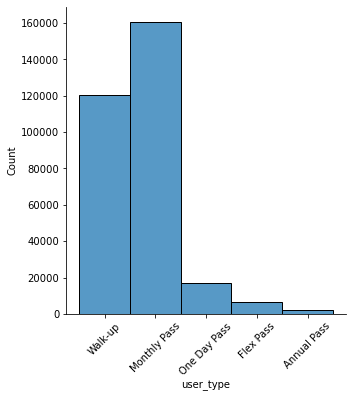

In [15]:
sns.displot(df_LA["user_type"]).set_xticklabels(rotation=45)

### The pricing system

Below the prices are listed which are in place at the moment (december 2021): https://t1p.de/xop9n<br>
The same prices have been in place since August of 2018: https://t1p.de/6cep

<table style="float: left">
  <tr>
    <th>"user_type" in dataset</th>
    <th>name on website</th>
    <th>pricing</th>
  </tr>
  <tr>
    <td>Annual Pass</td>
    <td>365-Day PAss</td>
    <td>150/year & 1,75 after 30min</td>
  </tr>
  <tr>
    <td>Flex Pass</td>
      <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Monthly Pass</td>
    <td>30-Day Pass </td>
    <td>17/month & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>One Day Pass</td>
    <td>24-Hour Access</td>
    <td>5/day & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>Walk-Up</td>
    <td>1-Ride</td>
    <td>1.75 per 30min</td>
  </tr>
</table>


In June 2016 the following princing system was in place: https://t1p.de/spq7

<table style="float: left">
  <tr>
    <th>"user_type" in dataset</th>
    <th>name on website</th>
    <th>pricing</th>
  </tr>
  <tr>
    <td>Annual Pass</td>
    <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Flex Pass</td>
      <td>Flex Pass</td>
    <td>40/year & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>Monthly Pass</td>
    <td>Monthly Pass </td>
    <td>20/month & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>One Day Pass</td>
    <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Walk-Up</td>
    <td>1-Ride</td>
    <td>3.50 per 30min</td>
  </tr>
</table>

Prices have changed within 2018. Unfortunately, there is no information on the internet about what the prices were at the beginning of 2018. <br>
We now take a look at how often rides were started by the different user_types:

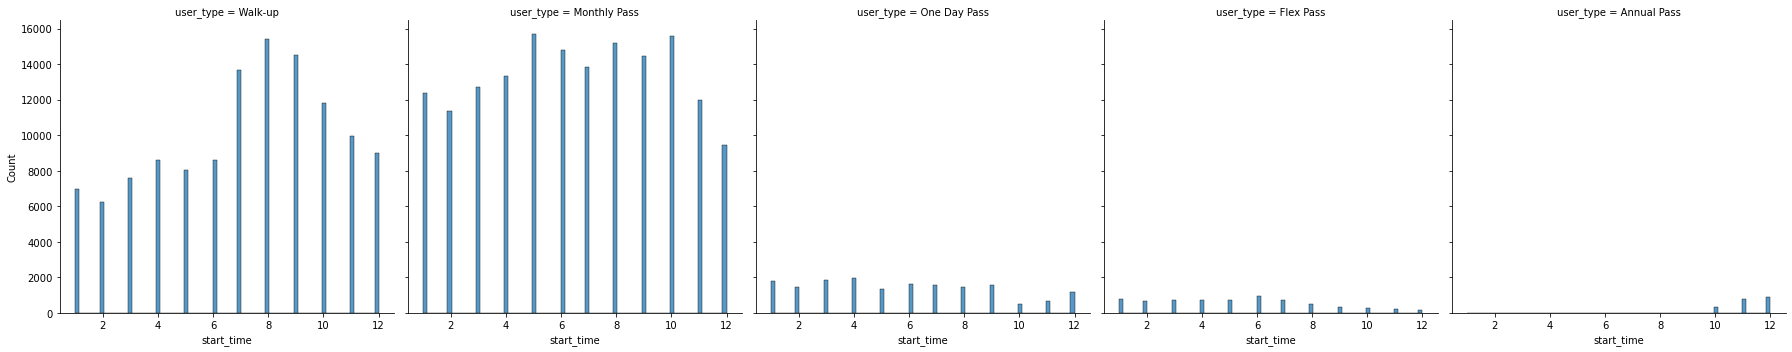

In [31]:
df_temp = df_LA.copy()
df_temp["start_time"] = df_temp["start_time"].dt.month
sns.displot(df_temp, x="start_time", col="user_type")

Having a closer look at the Annual Pass, because there were no rides in the first 8 months.

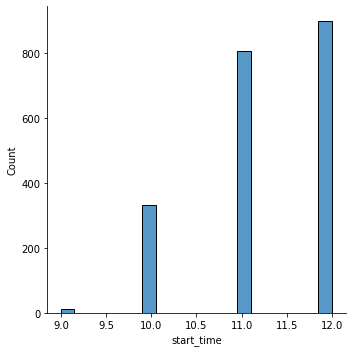

In [17]:
sns.displot(df_temp[df_temp["user_type"] == "Annual Pass"], x="start_time")

In [18]:
df_LA[df_LA["user_type"] == "Annual Pass"]["start_time"].describe(datetime_is_numeric=True)

count                             2049
mean     2018-11-24 10:45:31.039531264
min                2018-09-29 13:52:00
25%                2018-11-08 15:06:00
50%                2018-11-27 09:46:00
75%                2018-12-13 09:05:00
max                2018-12-31 22:46:00
Name: start_time, dtype: object

The first time a ride with the Annual Pass took place was on 2018-09-29. This observation is consistent with the information from above that the pricing system changed within 2018. The Annual Pass was probably only introduced within 2018.

#### Quantity of bought passes

The data does not include a User_ID or anything else that would allow us to deduce the number of passes sold. There was also no information on the Internet about how many passes were sold in 2018. <br>
We therefore have to leave out the revenue generated by the sale of passes from our analysis.

#### Final determination of a pricing model for the analysis

From the gathered information above, we determine the following specifications for later analysis.

**1:** We only pay attention to the fares that are payed by time, not the pre paid passes *(because we unfortunately do not have any user data)* <br>
**2:** We use for all user_types for which it is possible the prices that applyed from August 2020 *(because we have no information on the prices in the first half of 2018)*<br>
**2.1:** Because we only look at the fares that are paid by time (compare 1. specification) we don't have to set a prepaid price for the Fix Pass. The faires after 30 minutes we declare as 1.75 <br>

*(This means that in the analysis for all user_types except "walk-up" we calculate 1.75 for all started 30 minutes after the first 30 minutes and for "walk-up" we calculate 1.75 for all started 30 minutes.)* <br>



**3:** The price of a ride is credited to the hour in which the ride ends.

### Calculation of revenues

In [19]:
df_rev = df_LA.copy()
df_rev.loc[df_rev["user_type"] == "Walk-up", "revenue"] = np.ceil(df_LA["trip_duration_in_hours"]*2) *1.75
df_rev.loc[df_rev["user_type"] != "Walk-up", "revenue"] = np.ceil(df_LA["trip_duration_in_hours"]*2) *1.75 -1.75
df_rev[["user_type", "trip_duration_in_hours", "revenue"]].head(10)

,user_type,trip_duration_in_hours,revenue
0,Walk-up,0.350000,1.75
1,Walk-up,0.333333,1.75
2,Walk-up,0.316667,1.75
3,Monthly Pass,0.366667,0.00
4,Monthly Pass,0.750000,1.75
5,Monthly Pass,0.100000,0.00
6,Walk-up,0.200000,1.75
7,Walk-up,0.216667,1.75
8,Walk-up,0.133333,1.75
9,Monthly Pass,1.966667,5.25


We now have a look at how the revenues are distributed over the different hours of a day, the different days of a week and the different months of the year. We look at the absolute summed absolut revenues and the mean revenues per ride for all these periods.

In [36]:
df_temp = df_rev.copy()
df_temp["end_time_month"] = df_temp["end_time"].dt.month
df_temp["end_time_weekday"] = df_temp["end_time"].dt.weekday
df_temp["end_time_hour"] = df_temp["end_time"].dt.hour
month_sum = df_temp.groupby("end_time_month")["revenue"].sum()
month_mean = df_temp.groupby("end_time_month")["revenue"].mean()
weekday_sum = df_temp.groupby("end_time_weekday")["revenue"].sum()
weekday_mean = df_temp.groupby("end_time_weekday")["revenue"].mean()
hour_sum = df_temp.groupby("end_time_hour")["revenue"].sum()
hour_mean = df_temp.groupby("end_time_hour")["revenue"].mean()

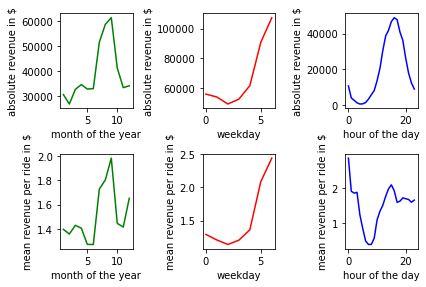

In [71]:
plt.subplot(2, 3, 1)
plt.plot(month_sum, "g")
plt.xlabel('month of the year')
plt.ylabel("absolute revenue in $")

plt.subplot(2, 3, 4)
plt.plot(month_mean, "g")
plt.xlabel('month of the year')
plt.ylabel("mean revenue per ride in $")

plt.subplot(2, 3, 2)
plt.plot(weekday_sum, "r")
plt.xlabel('weekday')
plt.ylabel("absolute revenue in $")

plt.subplot(2, 3, 5)
plt.plot(weekday_mean, "r")
plt.xlabel('weekday')
plt.ylabel("mean revenue per ride in $")

plt.subplot(2, 3, 3)
plt.plot(hour_sum, "b")
plt.xlabel('hour of the day')
plt.ylabel("absolute revenue in $")

plt.subplot(2, 3, 6)
plt.plot(hour_mean, "b")
plt.xlabel('hour of the day')
plt.ylabel("mean revenue per ride in $")

#plt.subplots_adjust(left=None, bottom=None, right=1, top=0.5, wspace=0.5, hspace=None)
plt.tight_layout()


todo: PLOT ÜBER DAS GANZE JAHR

Problem: mit plot sieht scheiße aus, guck hier:

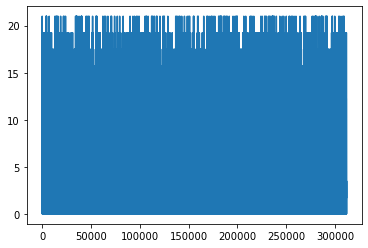

In [55]:
plt.plot(df_rev["revenue"])

#### Revenue per hour of the day

In [22]:
hour_sum

end_time_hour
0     10794.00
1      4126.50
2      2819.25
3      1408.75
4       728.00
5       831.25
6      1552.25
7      3437.00
8      5904.50
9      8228.50
10    13688.50
11    20553.75
12    30485.00
13    38641.75
14    41776.00
15    46669.00
16    48798.75
17    47673.50
18    40783.75
19    36135.75
20    26223.75
21    17997.00
22    12453.00
23     9068.50
Name: revenue, dtype: float64

In [23]:
hour_sum.describe()

count       24.000000
mean     19615.750000
std      17263.284891
min        728.000000
25%       3954.125000
50%      13070.750000
75%      36762.250000
max      48798.750000
Name: revenue, dtype: float64

Text(0, 0.5, 'revenues in $')

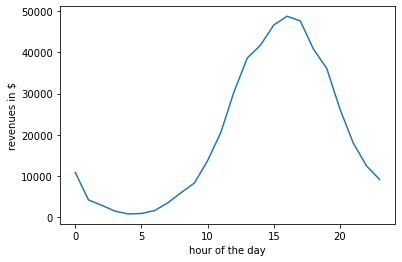

In [64]:
plt.plot(hour_sum)
plt.xlabel("hour of the day")
plt.ylabel("revenues in $")

In the 17th hour of the day the most revenues were generated (time between 16:00 and 17:00). In General most of the rides take place between 12:00 and 20:00.

#### Revenue per weekday

In [59]:
weekday_sum

end_time_weekday
0     55795.25
1     53851.00
2     49101.50
3     52393.25
4     61484.50
5     90774.25
6    107378.25
Name: revenue, dtype: float64

In [60]:
weekday_sum.describe()

count         7.000000
mean      67254.000000
std       22574.850445
min       49101.500000
25%       53122.125000
50%       55795.250000
75%       76129.375000
max      107378.250000
Name: revenue, dtype: float64

Text(0, 0.5, 'revenue in $')

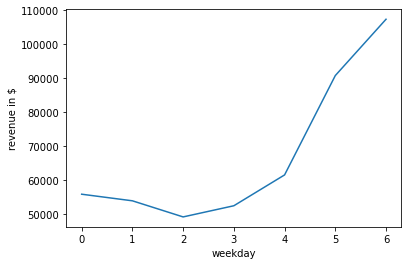

In [65]:
plt.plot(weekday_sum)
plt.xlabel('weekday')
plt.ylabel("revenue in $")

The most revenue was generated on sundays. In general weekend performed better than working days.

#### Revenue per month

In [26]:
month_sum

end_time_month
1     30609.25
2     26822.25
3     32695.25
4     34599.25
5     32819.50
6     32996.25
7     51497.25
8     58677.50
9     61355.00
10    41217.75
11    33372.50
12    34116.25
Name: revenue, dtype: float64

In [27]:
month_sum.describe()

count       12.0000
mean     39231.5000
std      11500.9435
min      26822.2500
25%      32788.4375
50%      33744.3750
75%      43787.6250
max      61355.0000
Name: revenue, dtype: float64

Text(0, 0.5, 'revenue in $')

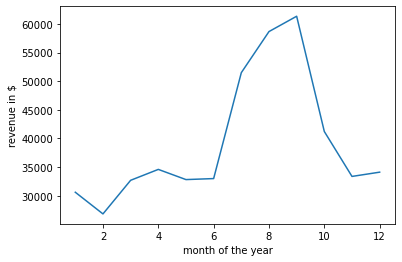

In [67]:
plt.plot(month_sum)
plt.xlabel('month of the year')
plt.ylabel("revenue in $")

The most revenue was generated in September in which 61355$ were earned. In general the summer months generated more revenue.

Text(0, 0.5, 'mean revenue per ride in $')

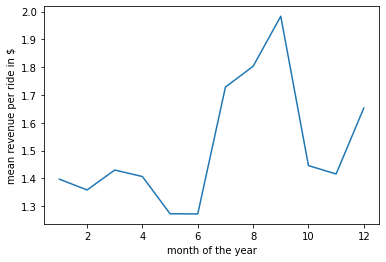

In [72]:
plt.plot(month_mean)
plt.xlabel('month of the year')
plt.ylabel("mean revenue per ride in $")

But the more generated revenue in the summer months is not only because of more rides, but also because the rides on average generated more profits.

#### Revenue for different stations

In [50]:
end_station_sum = df_temp.groupby("end_station_name")["revenue"].sum()
start_station_sum = df_temp.groupby("start_station_name")["revenue"].sum()

In [48]:
((end_station_sum + start_station_sum)/2).describe()

count      132.000000
mean      3566.500000
std       7492.573222
min         42.000000
25%        640.281250
50%       1660.750000
75%       3602.156250
max      56675.500000
Name: revenue, dtype: float64

In [49]:
((end_station_sum + start_station_sum)/2).sort_values()

end_station_name
4108                                       42.000
Expo Park/LAFC                             52.500
28th & Figueroa                            52.500
Banning's Landing                          80.500
San Julian & 12th                         164.500
                                          ...    
Windward & Main                         13131.125
Pacific & North Venice                  13730.500
Ocean Front Walk & North Venice         45036.250
Downtown Santa Monica E Line Station    45612.000
Ocean Front Walk & Navy                 56675.500
Name: revenue, Length: 132, dtype: float64

The station that accounted for the most revenue was "Ocean Front Walk & Navy". This was calculated by attributing half of a rides revenues to the start_station and the other half to the end_station. The station that generated the least revenue was "4108". 

@Marc hier vielleicht Heatmap für die besten/ schlechtesten Stationen?

## Coverage

Hier was auch immer uns zu Coverage einfällt. Irgendwas mit Heatmaps usw. Eigentlich geil, dass hier drüber am ende von Revenue schon HEatmaps genutzt wird. Da kann man schöne Überleitung draus bauen :^)